# Figure S14. Effect of optimization seeds on goodness-of-fit and E-I ratio

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pickle

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data of the main run and select the 200 subsample subjects:

In [3]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

# limit the optima to subsample
subsample = np.loadtxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), dtype=str)
subjects_optima = subjects_optima.loc[subjects_optima['sub'].isin(subsample)]

# select optimal runs and add demographics
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

Split data into two age groups for comparing ICCs between them:

In [4]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

## A. Goodness-of-fit comparison

In [6]:
gof_labels = {
    'gof': 'Goodness-of-fit',
    'fc_corr': 'FC correlation',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

Goodness-of-fit	0.246	0.806	0.0	0.01
FC correlation	0.327	0.744	0.0	0.01
FC difference	1.984	0.049	0.001	0.009
FCD KS distance	-2.035	0.043	-0.001	0.008


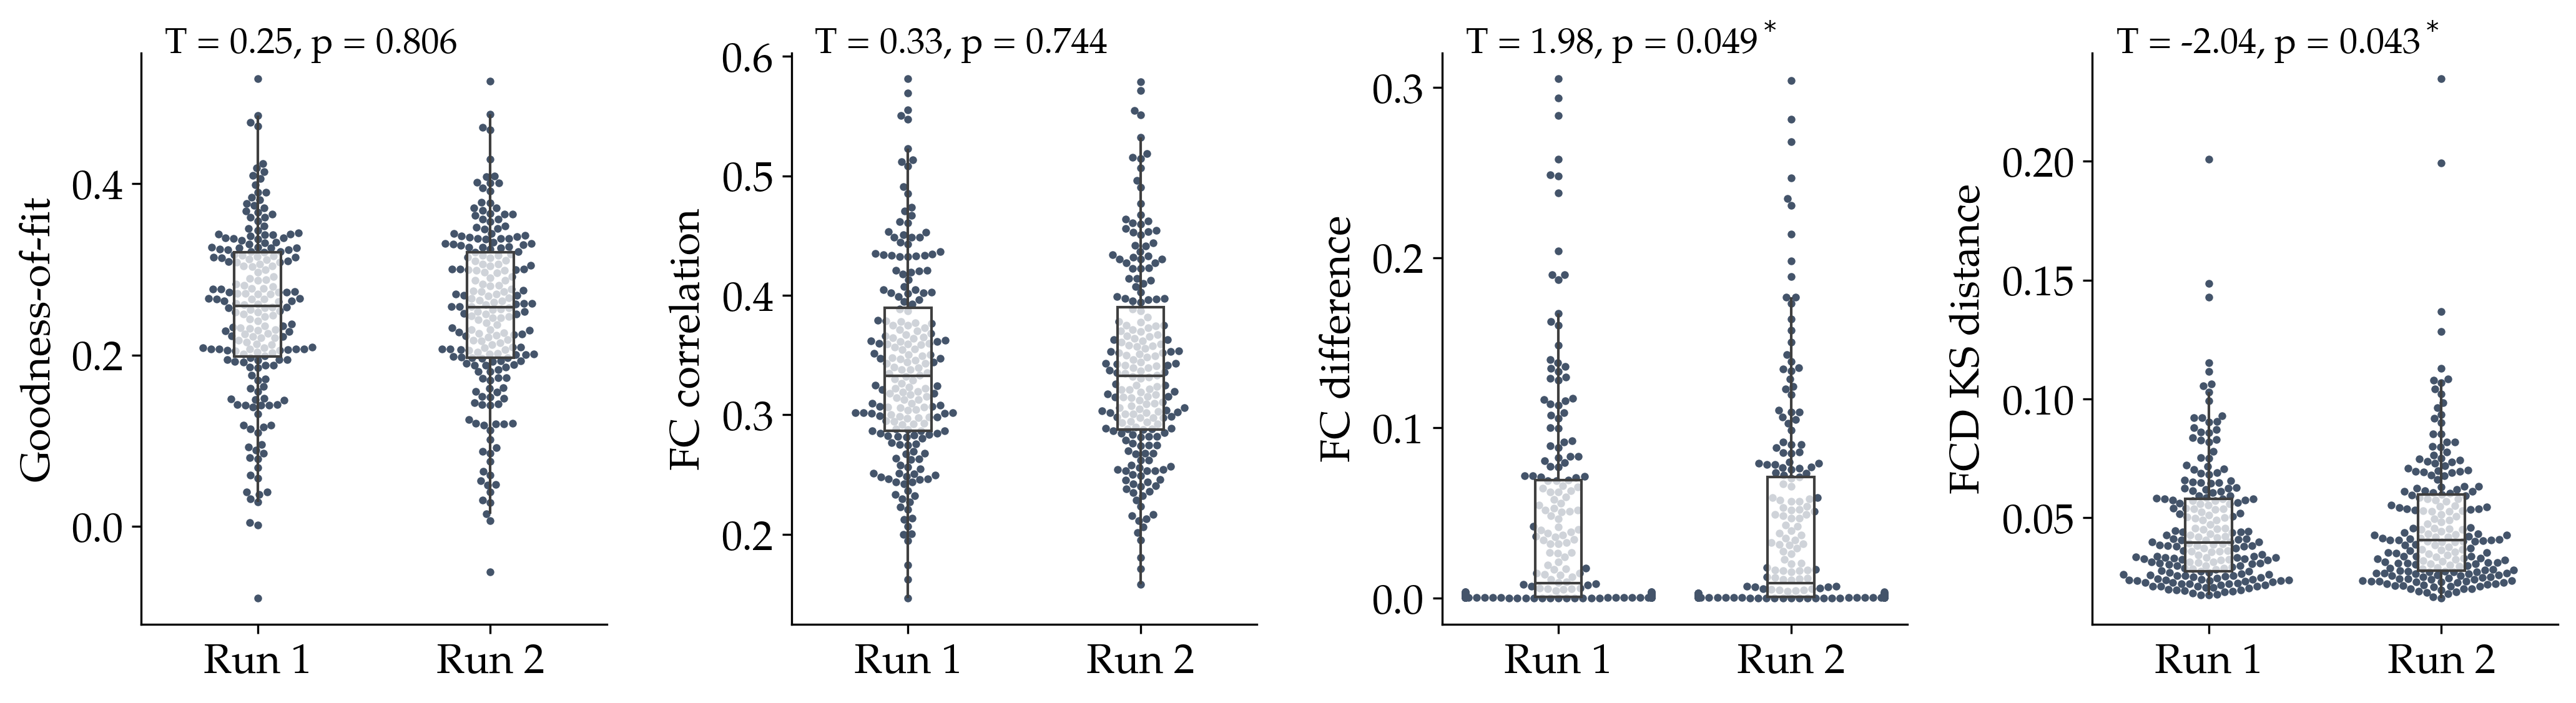

In [7]:
fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    sns.swarmplot(
        data=subjects_optima,
        x='SeedMW', y=col,
        s=3, color=thcolor,
        ax=ax
    )
    sns.boxplot(
        data=subjects_optima,
        x='SeedMW', y=col,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(['Run 1', 'Run 2'])
    ax.set_xlabel('')
    sns.despine()
    # add statistics
    t, p = scipy.stats.ttest_rel(
        subjects_optima.loc[subjects_optima['SeedMW']==1, col], 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col]
    )
    mean_diff = (
        subjects_optima.loc[subjects_optima['SeedMW']==1, col].values - 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col].values
    ).mean()
    sd_diff = (
        subjects_optima.loc[subjects_optima['SeedMW']==1, col].values - 
        subjects_optima.loc[subjects_optima['SeedMW']==2, col].values
    ).std()    
    if add_text:
        if p > 0.001:
            text = f'T = {t:.2f}, p = {p:.3f}'
        else:
            text = f'T = {t:.2f}, p < 0.001'
        if p < 0.05:
            text+=r'$^*$'
        text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
        text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
        ax.text(text_x, text_y, 
                text,
                color='black',
                size=14,
                multialignment='left')
    print(label, round(t, 3), round(p,3), round(mean_diff,3), round(sd_diff,3), sep="\t")
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [8]:
icc_opt = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    icc_df = pd.DataFrame(index=data.index, columns=[1, 2], dtype=float)
    for sub in data.index:
        for SeedMW in [1, 2]:
            icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'I_E']
    icc_opt.loc[parc] = stats.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])

In [9]:
icc_opt_by_age = pd.DataFrame(index=parcels, dtype=float)
for age in data_by_age.keys():
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(index=data_by_age[age].index, columns=[1, 2], dtype=float)
        for sub in data_by_age[age].index:
            for SeedMW in [1, 2]:
                icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'I_E']
        icc_opt_by_age.loc[parc, age] = stats.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])
icc_opt_by_age['all'] = icc_opt

       younger    older      all
count  100.000  100.000  100.000
mean     0.943    0.941    0.946
std      0.030    0.026    0.021
min      0.839    0.864    0.874
25%      0.927    0.922    0.934
50%      0.948    0.946    0.950
75%      0.966    0.960    0.961
max      0.987    0.985    0.982
T =0.5575935796150813, p = 0.5783805761507439


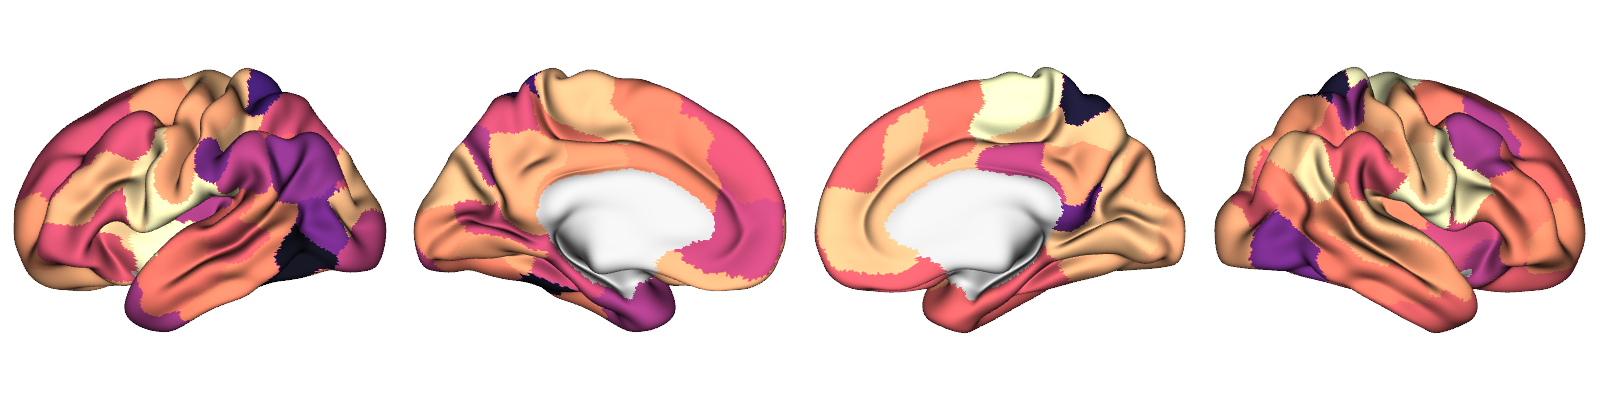

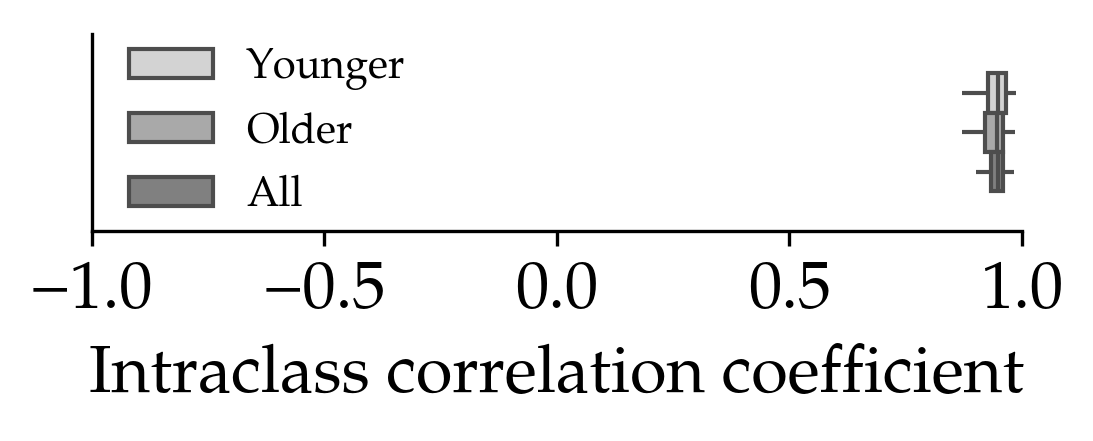

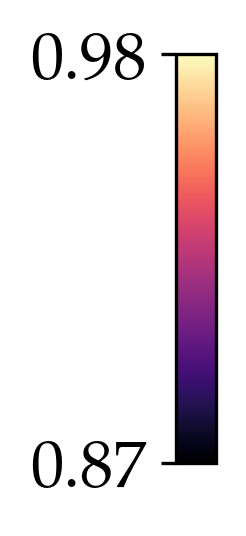

In [10]:
print(icc_opt_by_age.describe().round(3))
plot.plot_icc_by_age(icc_opt_by_age, 'schaefer-100')